In [1]:
# Mount folder from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import os

str_train_dir = "/content/drive/MyDrive/train_size_300"
str_valtest_dir = "/content/drive/MyDrive/valtest_size_300"
def get_data(path):
    class_names = os.listdir(path)
    image_paths = []
    labels = []
    for name in class_names:
        directory = os.path.join(path, name)
        class_path = [os.path.join(directory, f) for f in os.listdir(directory)]
        image_paths += class_path
        labels.extend([name] * len(class_path))

    return image_paths, labels


def get_training_data():
    return get_data(str_train_dir)


def get_test_data():
    return get_data(str_valtest_dir)

import pickle


def save_model(filepath, clf):
    pickle.dump(clf, open(filepath, "wb"))


def load_model(model_path: str):
    with open(model_path, "rb") as model_file:
        model = pickle.load(model_file)

    return model

In [4]:
from typing import List

import cv2
import numpy as np
from scipy.cluster.vq import kmeans, vq


CLUSTER_SIZE = 200


def extract_feature(images: List[str]):
    n = len(images)
    descriptors = []
    orb = cv2.ORB_create()

    # extract features
    for image_path in images:
        img = cv2.imread(image_path)
        features = orb.detect(img, None)
        _, img_descriptor = orb.compute(img, features)
        descriptors.append((image_path, img_descriptor))

    # reformat training descriptors
    concat_descriptors = descriptors[0][1]
    for image_path, descriptor in descriptors[1:]:
        concat_descriptors = np.vstack((concat_descriptors, descriptor))
    concat_descriptors = concat_descriptors.astype(float)

    # k-means clustering
    codebook, _ = kmeans(concat_descriptors, CLUSTER_SIZE, 1)

    # create histogram of training images
    img_features = np.zeros((n, CLUSTER_SIZE), "float32")
    for i in range(n):
        words, distance = vq(descriptors[i][1], codebook)
        for word in words:
            img_features[i][word] += 1

    return img_features, codebook

In [5]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.svm import SVC as svc 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score

def get_training_features():
    training_images, training_labels = get_training_data()
    img_features, codebook = extract_feature(training_images)
    return img_features, codebook, training_labels

## set search parameters for SVC classifier

# C: float, default=1.0
# Regularization parameter. The strength of the regularization is inversely proportional to C.
# Must be strictly positive. The penalty is a squared l2 penalty.

# kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
# Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used.
#
# degreeint, default=3
# Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.

rand_list_svc = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1),
             "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
             }

## set search parameters for KNN classifier

# n_neighborsint, default=5
# Number of neighbors to use by default for kneighbors queries.

# weights {‘uniform’, ‘distance’} or callable, default=’uniform’
# Weight function used in prediction. Possible values:

# ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.

# ‘distance’ : weight points by the inverse of their distance. 

rand_list_knn = {
                    'n_neighbors':  [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)],
                    'weights': ['uniform','distance'],
                    'metric': ['euclidean','manhattan','chebyshev','minkowski'] ,
                    }

## set search parameters for Random Forests classifier

# n_estimators int, default=100
# The number of trees in the forest.


# criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
# The function to measure the quality of a split. 
# max_depth int, default=None
# The maximum depth of the tree. 

rand_list_rf = {'bootstrap': [True, False],
               'max_depth': [5, 10, 20, 30, 40, 50, None],
               'criterion': ['gini','entropy'],
               'n_estimators': [10, 30, 100, 200]}


def train_model(X,Y,model_str = 'rf'):
   
    if model_str == 'rf':
        mdl = RandomForestClassifier()
        mdl2 = RandomizedSearchCV(mdl, param_distributions = rand_list_rf, n_iter = 200, n_jobs = 4, cv = 3, random_state = 7, scoring = "accuracy") 
        mdl2.fit(X, Y)
        print("Best RF estimator found by Random search:")
        print(mdl2.best_estimator_)
        return mdl2
    elif model_str == 'svm':
        mdl = svc(probability = True)
        mdl2 = RandomizedSearchCV(mdl, param_distributions = rand_list_svc, n_iter = 200, n_jobs = 4, cv = 3, random_state = 7, scoring = "accuracy") 
        mdl2.fit(X, Y)
        print("Best svm estimator found by Random search:")
        print(mdl2.best_estimator_)
        return mdl2
    elif model_str == 'knn':
        mdl = KNeighborsClassifier()
        mdl2 = RandomizedSearchCV(mdl, param_distributions = rand_list_knn, n_iter = 200, n_jobs = 4, cv = 3, random_state = 7, scoring = "accuracy")
        mdl2.fit(X, Y) 
        print("Best knn estimator found by Random search:")
        print(mdl2.best_estimator_)
        return mdl2
    elif model_str == 'nbc':
        mdl2 = GaussianNB()
        mdl2.fit(X, Y)
        return mdl2



In [6]:
train_features, codebook, train_labels = get_training_features()
test_images, test_labels = get_test_data()


KeyboardInterrupt: ignored

In [6]:
test_images, test_labels = get_test_data()

In [ ]:
# save train features and codebook
save_model("/content/drive/MyDrive/ML_BOW_trainfeatures.pkl",train_features)
save_model("/content/drive/MyDrive/ML_BOW_codebook.pkl",codebook)

In [ ]:
rf_mdl = train_model(train_features,np.array(train_labels),model_str = 'rf')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 112 is smaller than n_iter=200. Running 112 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best RF estimator found by Random search:
RandomForestClassifier(max_depth=40, n_estimators=200)


In [ ]:
save_model("/content/drive/MyDrive/ML_BOW_RFmdl.pkl",rf_mdl)

In [ ]:
knn_mdl = train_model(train_features,np.array(train_labels),model_str = 'knn')

Best knn estimator found by Random search:
KNeighborsClassifier(metric='euclidean', n_neighbors=37, weights='distance')


In [ ]:
save_model("/content/drive/MyDrive/ML_BOW_KNNmdl.pkl",knn_mdl)

In [ ]:
nbc_mdl = train_model(train_features,np.array(train_labels),model_str = 'nbc')

In [ ]:
save_model("/content/drive/MyDrive/ML_BOW_NBCmdl.pkl",nbc_mdl)

In [ ]:
svm_mdl = train_model(train_features,np.array(train_labels),model_str = 'svm')

Best svm estimator found by Random search:
SVC(C=11.782228970785825, gamma=0.5555849133282118, kernel='poly',
    probability=True)


In [ ]:
save_model("/content/drive/MyDrive/ML_BOW_SVMmdl.pkl",svm_mdl)

In [7]:
import cv2
import numpy as np
from scipy.cluster.vq import vq

CLUSTER_SIZE = 200


def evaluate_model(estimator_path: str, codebook_path: str):
    estimator = load_model(estimator_path)
    codebook = load_model(codebook_path)
    orb = cv2.ORB_create()
    test_images, test_labels = get_test_data()
    n = len(test_images)
    test_descriptors = []
    # extract features
    for image_path in test_images:
        img = cv2.imread(image_path)
        features = orb.detect(img, None)
        _, img_descriptor = orb.compute(img, features)
        test_descriptors.append((image_path, img_descriptor))

    img_features = np.zeros((n, CLUSTER_SIZE), "float32")
    # create histogram of test images
    for i in range(n):
        words, distance = vq(test_descriptors[i][1], codebook)
        for word in words:
            img_features[i][word] += 1

    predictions = estimator.predict(img_features)
    y_pred = predictions
    correct = 0
    for i in range(n):
        if predictions[i] == test_labels[i]:
            correct += 1

    accuracy = correct / n
    mdl_str = estimator_path.split('_',2)
    print(classification_report(test_labels, y_pred, target_names=target_names))
    cm = confusion_matrix(test_labels, y_pred, labels=target_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
    disp.plot()
    plt.title('Confusion matrix - '+mdl_str[2][:-7])
   
    plt.tight_layout()
    plt.show()
    return round(accuracy, 2), predictions

Predicting Image labels on the test set
--------------------------Evaluating NBC using Bag of Visual Words-------------------------------------
              precision    recall  f1-score   support

     cheetah       0.66      0.43      0.52       104
         fox       0.31      0.28      0.29        75
       hyena       0.30      0.33      0.31        92
        lion       0.37      0.30      0.33        88
       tiger       0.39      0.72      0.50        81
        wolf       0.29      0.23      0.25        79

    accuracy                           0.38       519
   macro avg       0.39      0.38      0.37       519
weighted avg       0.40      0.38      0.38       519



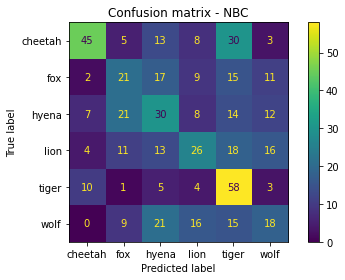

--------------------------Evaluating KNN using Bag of Visual Words-------------------------------------
              precision    recall  f1-score   support

     cheetah       0.61      0.53      0.57       104
         fox       0.43      0.36      0.39        75
       hyena       0.33      0.36      0.35        92
        lion       0.34      0.28      0.31        88
       tiger       0.41      0.70      0.52        81
        wolf       0.30      0.22      0.25        79

    accuracy                           0.41       519
   macro avg       0.41      0.41      0.40       519
weighted avg       0.41      0.41      0.40       519



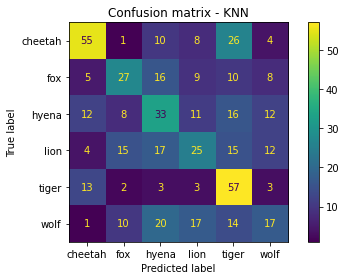

--------------------------Evaluating RF using Bag of Visual Words-------------------------------------
              precision    recall  f1-score   support

     cheetah       0.55      0.56      0.55       104
         fox       0.43      0.25      0.32        75
       hyena       0.28      0.38      0.32        92
        lion       0.32      0.30      0.31        88
       tiger       0.47      0.57      0.51        81
        wolf       0.29      0.23      0.25        79

    accuracy                           0.39       519
   macro avg       0.39      0.38      0.38       519
weighted avg       0.39      0.39      0.38       519



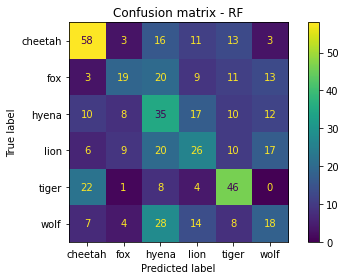

--------------------------Evaluating SVM using Bag of Visual Words-------------------------------------
              precision    recall  f1-score   support

     cheetah       0.59      0.55      0.57       104
         fox       0.32      0.32      0.32        75
       hyena       0.36      0.42      0.39        92
        lion       0.33      0.34      0.33        88
       tiger       0.55      0.51      0.53        81
        wolf       0.28      0.27      0.27        79

    accuracy                           0.41       519
   macro avg       0.41      0.40      0.40       519
weighted avg       0.41      0.41      0.41       519



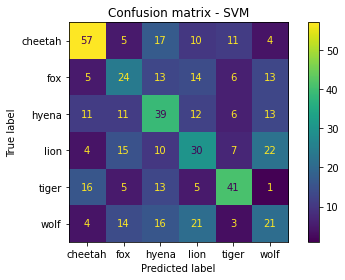

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

print("Predicting Image labels on the test set")
target_names = ['cheetah','fox','hyena','lion','tiger','wolf']
Model_names=['NBC','KNN','RF','SVM']
acc_list = []
for model in Model_names:
    print(f"--------------------------Evaluating {model} using Bag of Visual Words-------------------------------------")
    acc ,y_pred = evaluate_model("/content/drive/MyDrive/ML_BOW_"+model+"mdl.pkl", "/content/drive/MyDrive/ML_BOW_codebook.pkl")
    acc_list.append(acc)
 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'ML models: Accuracy')

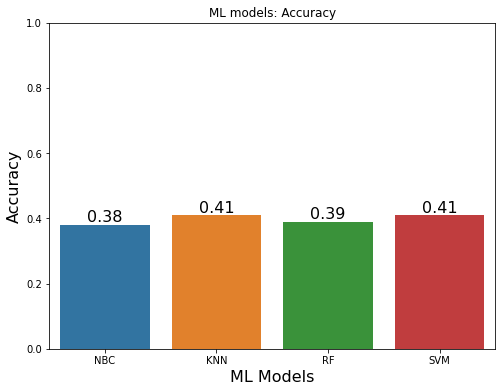

In [16]:
#plot accuracies of ML models
import seaborn as sns


plt.figure(figsize=(8, 6))
splot=sns.barplot(Model_names,acc_list)
plt.xlabel("ML Models", size=16)
plt.ylabel("Accuracy", size=16)
plt.bar_label(splot.containers[0],size=16)
plt.ylim([0,1])
plt.title('ML models: Accuracy')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'NBC'),
  Text(1, 0, 'KNN'),
  Text(2, 0, 'RF'),
  Text(3, 0, 'SVM'),
  Text(4, 0, 'Transfer Learning (InceptionResNetV2)'),
  Text(5, 0, 'afterFineTuning')])

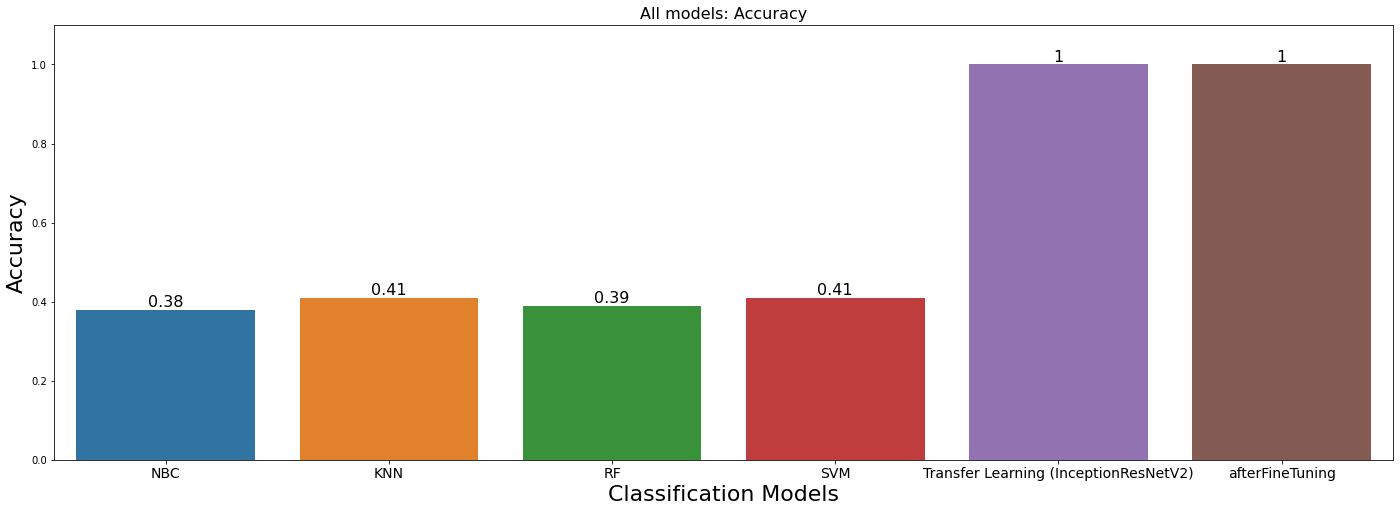

In [30]:
#plot accuracies of ML and DL models
import seaborn as sns

Model_names=['NBC','KNN','RF','SVM','Transfer Learning (InceptionResNetV2)','afterFineTuning']
plt.figure(figsize=(24, 8))
#acc_list.extend([1.0,1.0])
splot=sns.barplot(Model_names,acc_list)
plt.xlabel("Classification Models", size=22)
plt.ylabel("Accuracy", size=22)
plt.bar_label(splot.containers[0],size=16)
plt.ylim([0,1.1])
plt.title('All models: Accuracy', size=16)
plt.xticks(fontsize=14, rotation=0)

In [14]:
acc_list

[0.38, 0.41, 0.39, 0.41, 1.0, 1.0, 1.0, 1.0]